# Intro to Time Series Analysis

Here we will be going over the basic methods for building simple time series models, using toy datasets. Then we will introduce the concept of seasonality and fit a model for our bikes dataset (see "Data Cleaning and Visualization"). 

In [1]:
import os 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Autoregressive (AR) Model

Autoregressive models are based on the idea that, in data with a time component, two (or more) consecutive points are consistently correlated.  That is, one can make an accurate out of sample prediction by just using the most recent data point as an input to the model. 

This may sound confusing at first, but an example should clear things up. We will begin by generating a sample of time series data which is autocorrelated. The formula will look someting like this:

### $x_t$ = $\phi$$x_{t-1}$ + $\omega$   ;   $\omega$~$N$(0,1)

Where the subscript *t* and *t-1* denote which time *t* we are predicting and it's first lag. Additionally $\omega$ represents a normal random variable with mean=0, and variance=1 (i.e. $N$(0, 1)). 

Here we will make $\phi$ = 0.8

Is this process stationary (i.e. no trend or change in volatility): True
Is this process invertible (i.e. can be represented as infinite moving average): True


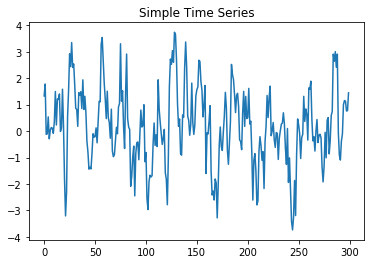

In [2]:
np.random.seed(10)

# generate AR(1) process where phi = 0.8
ar_process = ArmaProcess(ar=[1, -0.8], ma=[1]) 
sample = ar_process.generate_sample(300)

print(f'Is this process stationary (i.e. no trend or change in volatility): {ar_process.isstationary}')
print(f'Is this process invertible (i.e. can be represented as infinite moving average): {ar_process.isinvertible}')
plt.plot(sample)
plt.title('Simple Time Series'); 

Ok, there is the time series! Now, here's the real question:
### Why don't we just model this using simple linear regression?

It's an excellent question. One that I myself had while learning time series analysis. If the expected value of our time series (i.e. the average) is zero, then why not fit a flat line and be done with it? 

The answer comes down to the error values when we fit a simple linear model like that. Our error values are going to be correlated with their neighbors. Again, an example is going to be the best way to show this.

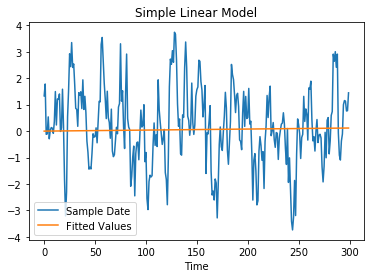

In [3]:
data = pd.DataFrame(data=sample, columns=['x'])

line = OLS(data.x, data.index).fit() # fits simple line with only Time as input (no constant)
fig, ax = plt.subplots()

ax.plot(data.index, data.x, label='Sample Date')
ax.plot(line.fittedvalues, label='Fitted Values')
ax.set_xlabel('Time')
ax.set_title('Simple Linear Model')
ax.legend();

Not a great result, huh? 

I wonder what the residuals look like...

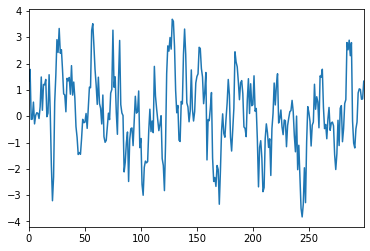

In [4]:
line.resid.plot()

They looks nearly exactly the same as our original data! Since our simple line was effectively predicting zero for every value, our residuals are all effectively the original observations. 

Here come the important question, the question the simple AR model is based on: do these errors correlate with our previous input values?

In [5]:
data['x_1'] = data.x.shift() # simple moves the x column down one, so we can calculate correlation 
data['linear_error'] = line.resid.shift()
data.head()

,x,x_1,linear_error
0,1.331587,NaN,NaN
1,1.780548,1.331587,1.331587
2,-0.120962,1.780548,1.780159
3,-0.105153,-0.120962,-0.121739
4,0.537213,-0.105153,-0.106320


In [6]:
data[['x_1', 'linear_error']].corr()

,x_1,linear_error
x_1,1.000000,0.999735
linear_error,0.999735,1.000000


Look at that! A correlation coefficient of 0.75--that very high! 

I wonder what happens if we calculate the correlation of values two or three steps back?

In [7]:
data['x_2'] = data.x.shift(2)
data['x_3'] = data.x.shift(3)
data[['x', 'x_1', 'x_2', 'x_3']].corr()

,x,x_1,x_2,x_3
x,1.000000,0.749494,0.539445,0.359830
x_1,0.749494,1.000000,0.749470,0.539106
x_2,0.539445,0.749470,1.000000,0.749331
x_3,0.359830,0.539106,0.749331,1.000000


There appears to be some sort of a diminishing correlation going on here. The more steps we take back from x, the more the correlation goes down. 

I'm going to skip to the chase here and show you an Autocorrelation Plot, which depicts the level of correlation between a vector and it's lagged values. 

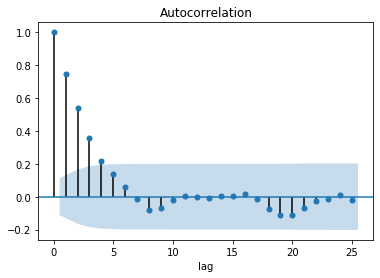

In [8]:
fig, ax = plt.subplots()
plot_acf(data.x, ax=ax)
ax.set_xlabel('lag');

Important note: the first peak (at t=0) will (should?) always equal 1 -- because how correlated is something with itself?   

The blue bubble idicates significance, but here we see 4 significant peaks when we recall that our original sample was generated with the following equation: 

### $x_t$ = 0.8 $x_{t-1}$ + $\omega$

So what's going on here? Let's refer back to our correlation matrix:

We have $x_t$ and it's first lag, $x_{t-2}$, which are highly correlated, which is to say that $x_t$ is dependent upon the value of $x_{t-1}$. Great, that's not too difficult. However, what, then, is $x_{t-1}$ dependent upon? Of course it's $x_{t-2}$. Which is reflected in the correlation matrix, where $x_{t-1}$ and $x_{t-2}$ are also highly correlated. 

So then if we know that $x_t$ depends upon $x_{t-1}$ and that $x_{t-1}$ depends upon $x_{t-2}$ -- it logically follows that $x_t$ has *some* dependence upon $x_{t-2}$ as well!  

The real question is how does that knowledge help us find the correct model to fit to the data. Well, what it helps us understand is the application of the Partial Autocorrelation Function, which effectively evaluates the correlation between $x_t$ and it's various lags, while ignoring those in-between interactions whice we just discussed. 

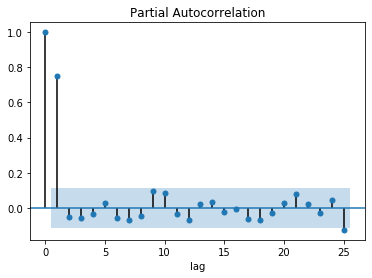

In [9]:
f, ax = plt.subplots()
plot_pacf(data.x, ax=ax)
ax.set_xlabel('lag');

Fantastic, now the case is clear for us! The single significant peak (remember we ignore the peak at lag=0) is indicitive of an AR(1) process! Let's fit an AR(1) model to the sample data. 

In [10]:
ar1 = ARMA(endog=data.x, order=[1,0]).fit()

In [11]:
ar1.params

const      0.211946
ar.L1.x    0.748771
dtype: float64

Remember when we generated the sample data and set $\phi$ = 0.8? Well look at what our model chose as the $\phi$ parameter (i.e. ar.L1.x)?   
0.74 is pretty darn close to 0.8. 

Now lets see how this model stacks up to the simple linear model we saw earlier.

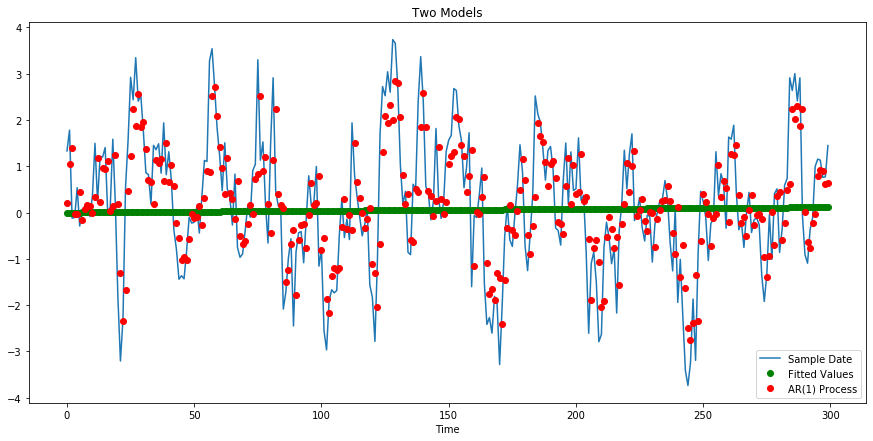

In [12]:
fig, ax = plt.subplots(figsize=(15,7))

ax.plot(data.index, data.x, label='Sample Date')
ax.plot(line.fittedvalues, 'go', label='Fitted Values')
ax.set_xlabel('Time')
ax.set_title('Two Models')

ax.plot(ar1.fittedvalues, 'ro', label='AR(1) Process')
ax.legend();

What we see above are the fitted values for each of our two models, and *what an improvement* in the AR(1) model!

Let's quantify the imporvement with a mean squared error calculation.

In [13]:
line_mse = np.mean(line.resid**2)
ar1_mse = np.mean(ar1.resid**2)

print(f'MSE for our linear model is: {line_mse}')
print(f'MSE for our AR(1) model is: {ar1_mse}')

MSE for our linear model is: 2.099908525788839
MSE for our AR(1) model is: 0.9090072968995679


## Predicting Bike Rides

In [14]:
bikes = pd.read_csv('cleaned_bikes.csv', index_col=0)
bikes.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,total_rides,year,time_combined
0,2011-01-01,Winter,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,2011,2011-01-01 00:00:00
1,2011-01-01,Winter,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,2011,2011-01-01 01:00:00
2,2011-01-01,Winter,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,2011,2011-01-01 02:00:00
3,2011-01-01,Winter,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,2011,2011-01-01 03:00:00
4,2011-01-01,Winter,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,2011,2011-01-01 04:00:00


In [15]:
grouped = bikes[['total_rides', 'dteday']].groupby('dteday').agg(sum)

In [16]:
xt_full = pd.Series(grouped.total_rides.values, index=pd.to_datetime(grouped.index))
xt_full.head()

dteday
2011-01-01     985
2011-01-02     801
2011-01-03    1349
2011-01-04    1562
2011-01-05    1600
dtype: int64

In [17]:
split = round(len(xt_full)*0.8)
xt, xt_test = xt_full[:split], xt_full[split:]

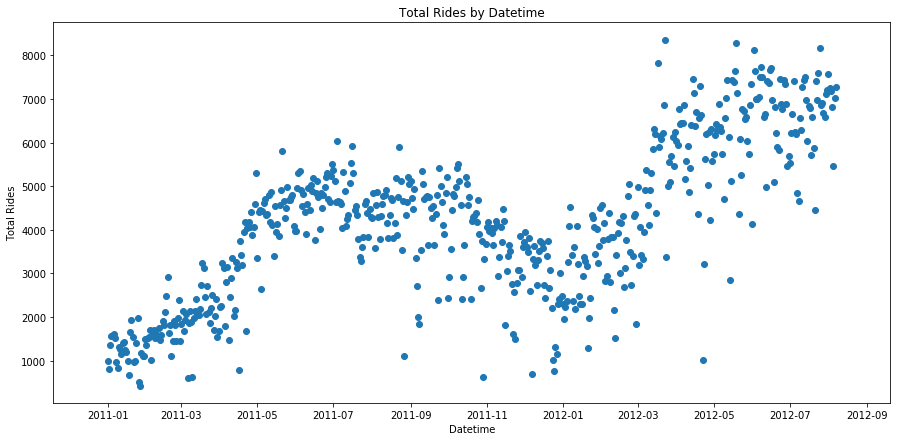

In [18]:
fig, ax = plt.subplots(figsize=(15,7))

ax.scatter(xt.index, xt)
ax.set_title('Total Rides by Datetime')
ax.set_xlabel('Datetime')
ax.set_ylabel('Total Rides'); 

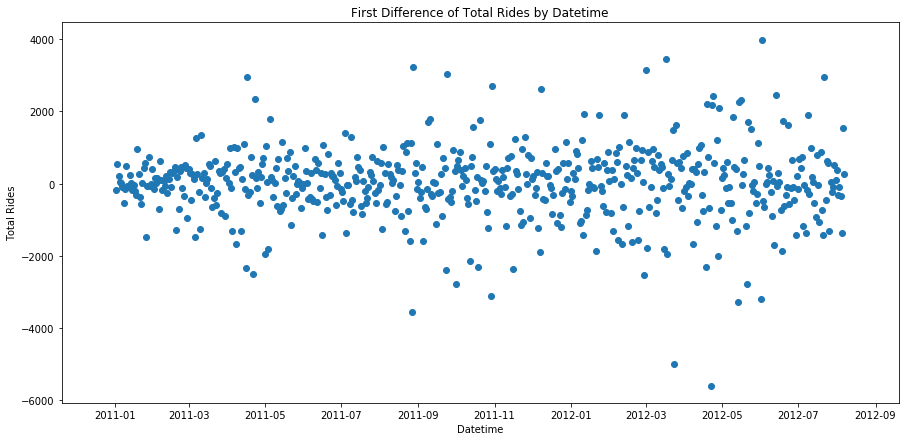

In [19]:
fig, ax = plt.subplots(figsize=(15,7))

ax.scatter(xt.index, xt.diff())
ax.set_title('First Difference of Total Rides by Datetime')
ax.set_xlabel('Datetime')
ax.set_ylabel('Total Rides'); 

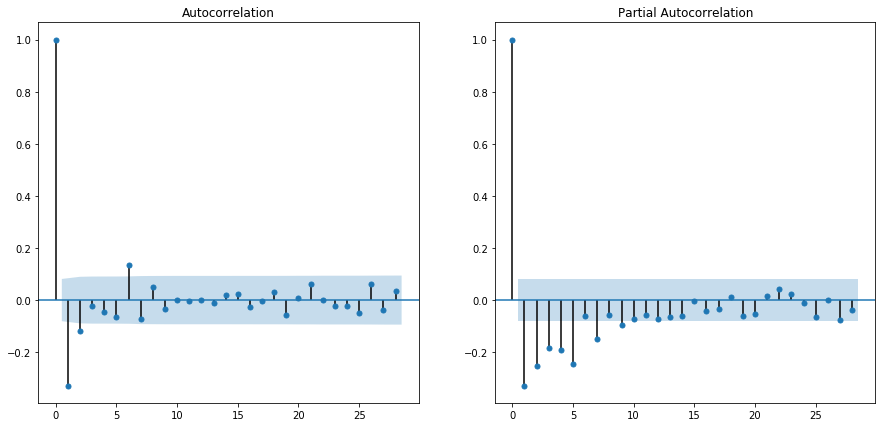

In [20]:
fig, ax = plt.subplots(1,2,figsize=(15,7))

plot_acf(xt.diff()[1:], ax=ax[0])
plot_pacf(xt.diff()[1:], ax=ax[1]);

In [21]:
arima51 = ARIMA(xt, order=[5,1,0]).fit()

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


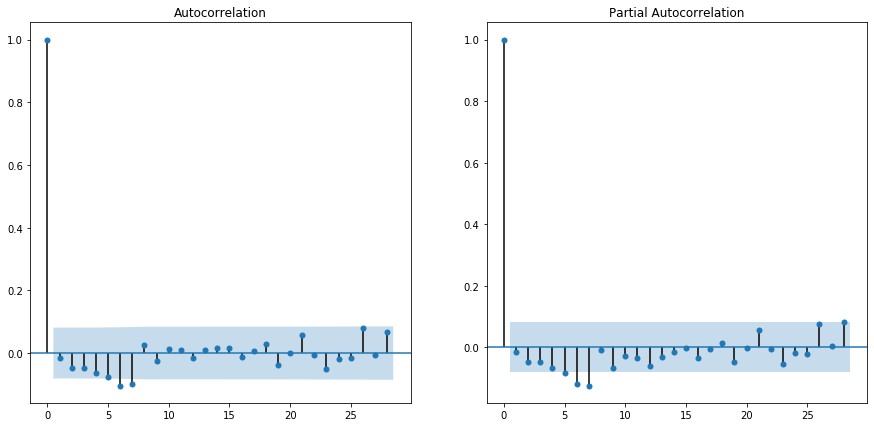

In [22]:
fig, ax = plt.subplots(1,2,figsize=(15,7))

plot_acf(arima51.resid, ax=ax[0])
plot_pacf(arima51.resid, ax=ax[1]);

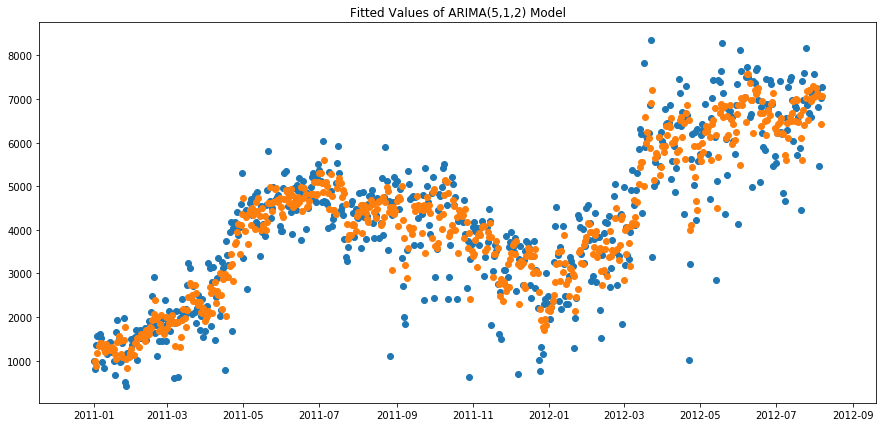

In [23]:
fig, ax = plt.subplots(figsize=(15,7))

ax.scatter(xt.index, xt, label='Total Bikes')
ax.scatter(xt.index[-len(arima51.fittedvalues):], arima51.predict(typ='levels'), label='Fitted Values')
ax.set_title('Fitted Values of ARIMA(5,1,2) Model');

So these are our fitted values, but let's evaluate how we did with our test set. 

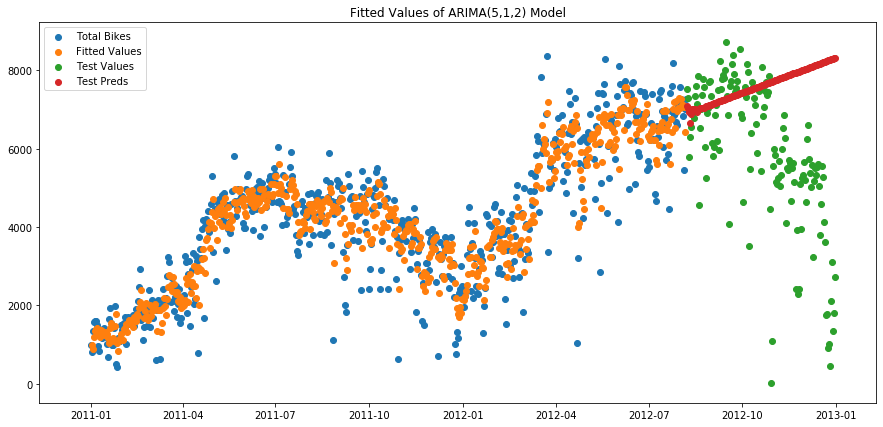

In [24]:
test_preds = arima51.predict(start=xt_test.index[0], end=xt_test.index[-1], typ='levels')

fig, ax = plt.subplots(figsize=(15,7))

ax.scatter(xt.index, xt, label='Total Bikes')
ax.scatter(xt.index[-len(arima51.fittedvalues):], arima51.predict(typ='levels'), label='Fitted Values')
ax.scatter(xt_test.index, xt_test, label='Test Values')
ax.scatter(xt_test.index, test_preds, label='Test Preds')
ax.set_title('Fitted Values of ARIMA(5,1,2) Model')
ax.legend();

Not a great result! 

This is a good opportunity to introduce the concept of seasonality. Seasonality is the idea that values can be correlated with other values from the distant past. 

When we plottted the ACF and PACF for our models residuals, we only went upto a lag=30. What would happen if we increased that number to 370?

//anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


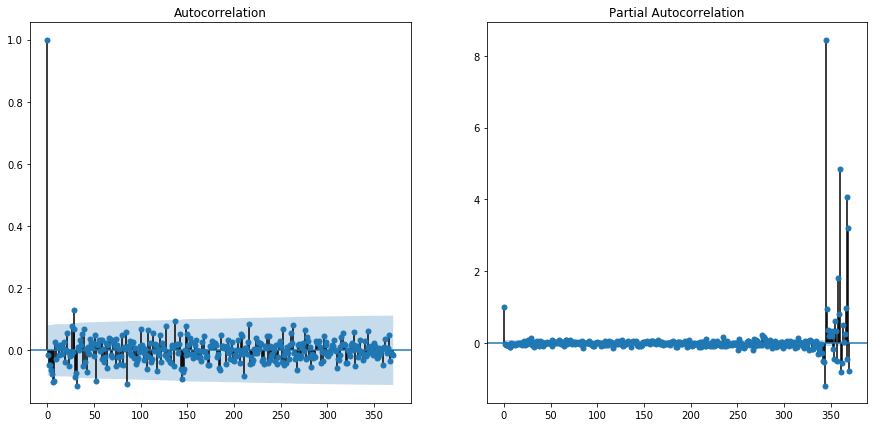

In [25]:
fig, ax = plt.subplots(1,2,figsize=(15,7))

plot_acf(arima51.resid, lags=370, ax=ax[0])
plot_pacf(arima51.resid, lags=370, ax=ax[1]);

Look at that! The PACF shows that there is additional complexity which we didn't account for in our original model! Since we know that the data we are working with is daily data, it makes sense that the value for $x_t$ would be autocorrelated with the values $x_{t-365}$. Let's incorporate a seasonal component to our model.

In [26]:
if os.path.exists('sarima.pkl'):
    sarima = sm.load('sarima.pkl')
else:
    sarima = SARIMAX(xt, order=[5,1,0], seasonal_order=[1,0,0,365]).fit()
    sarima.save('sarima.pkl')

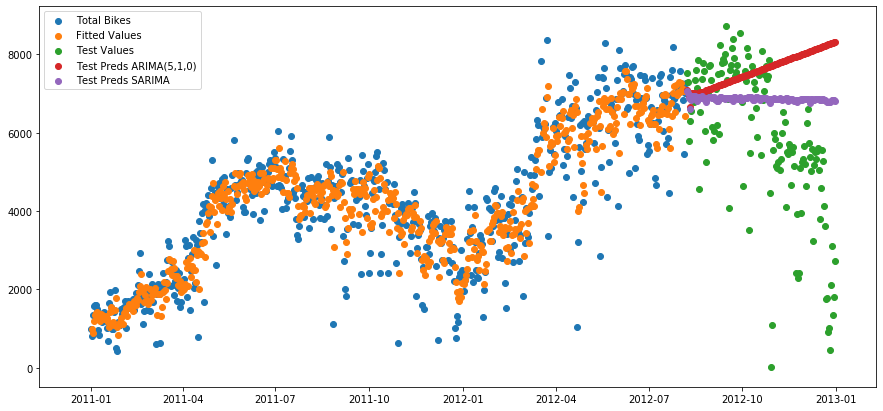

In [28]:
test_preds = arima51.predict(start=xt_test.index[0], end=xt_test.index[-1], typ='levels')
test_preds_sarima = sarima.predict(start=xt_test.index[0], end=xt_test.index[-1], typ='levels')

fig, ax = plt.subplots(figsize=(15,7))

ax.scatter(xt.index, xt, label='Total Bikes')
ax.scatter(xt.index[-len(arima51.fittedvalues):], arima51.predict(typ='levels'), label='Fitted Values')
ax.scatter(xt_test.index, xt_test, label='Test Values')
ax.scatter(xt_test.index, test_preds, label='Test Preds ARIMA(5,1,0)')
ax.scatter(xt_test.index, test_preds_sarima, label='Test Preds SARIMA')
ax.legend();

Hmm a couple of things to note here: 
1.) The model I fit took a long tiem to converge on a solution. Nearly 10 minutes on my personal laptop. 
2.) I think we are limited by the lack of data we have. When introducing a seasonal effect, we would need MANY, many years worth of data in order for the model to accurately predict the dip in that comes with the changing season. 

Maybe in lieu of multiple years of data, we can introduce exogenous variables into the data to increase the accuracy. 

In [29]:
grouped = bikes[['total_rides', 'dteday', 'temp']].groupby('dteday').agg({'total_rides':sum, 'temp':np.mean})

In [30]:
split = round(len(grouped)*0.8)
xt, xt_test = grouped[:split], grouped[split:]

In [31]:
arimax = SARIMAX(endog=xt.total_rides, exog=xt.temp, order=[5,1,0]).fit()

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


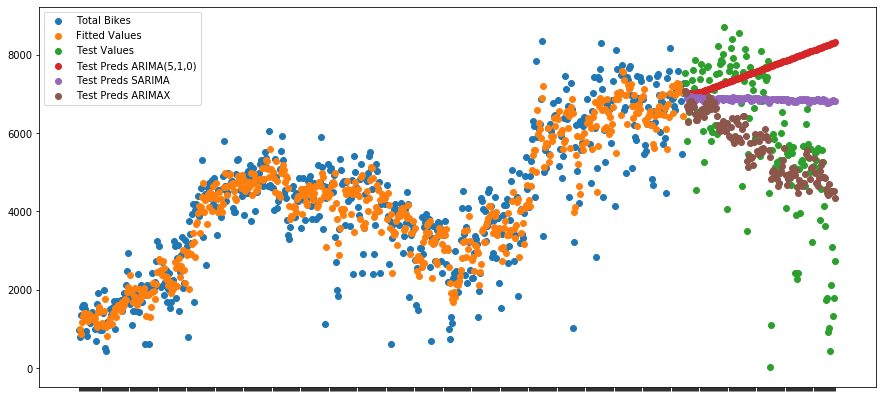

In [43]:
# test_preds = arima51.predict(start=xt_test.index[0], end=xt_test.index[-1], typ='levels')
# test_preds_sarima = sarima.predict(start=xt_test.index[0], end=xt_test.index[-1], typ='levels')
test_preds_arimax = arimax.predict(exog=xt_test.temp.values.reshape(len(xt_test), 1), start=xt_test.index[0], end=xt_test.index[-1], typ='levels')

fig, ax = plt.subplots(figsize=(15,7))

ax.scatter(xt.index, xt.total_rides, label='Total Bikes')
ax.scatter(xt.index[-len(arima51.fittedvalues):], arima51.predict(typ='levels'), label='Fitted Values')
ax.scatter(xt_test.index, xt_test.total_rides, label='Test Values')
ax.scatter(xt_test.index, test_preds, label='Test Preds ARIMA(5,1,0)')
ax.scatter(xt_test.index, test_preds_sarima, label='Test Preds SARIMA')
ax.scatter(xt_test.index, test_preds_arimax, label='Test Preds ARIMAX')
ax.set_xticklabels([None])
ax.legend();

Just by adding temperature to our model as an exogenous variable, we've drastically improved our forecasts.

In [44]:
if os.path.exists('sarimax.pkl'):
    sarimax = sm.load('sarimax.pkl')
else:
    sarimax = SARIMAX(endog=xt.total_rides, exog=xt.temp, order=[5,1,0], s=[1,0,0,365]).fit()
    sarimax.save('sarimax.pkl')

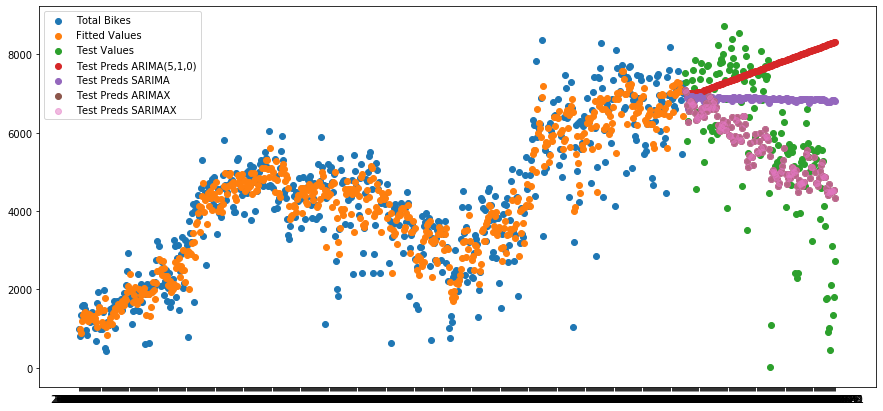

In [45]:
test_preds_sarimax = sarimax.predict(exog=xt_test.temp.values.reshape(len(xt_test), 1), start=xt_test.index[0], end=xt_test.index[-1], typ='levels')


fig, ax = plt.subplots(figsize=(15,7))

ax.scatter(xt.index, xt.total_rides, label='Total Bikes')
ax.scatter(xt.index[-len(arima51.fittedvalues):], arima51.predict(typ='levels'), label='Fitted Values')
ax.scatter(xt_test.index, xt_test.total_rides, label='Test Values')
ax.scatter(xt_test.index, test_preds, label='Test Preds ARIMA(5,1,0)')
ax.scatter(xt_test.index, test_preds_sarima, label='Test Preds SARIMA')
ax.scatter(xt_test.index, test_preds_arimax, label='Test Preds ARIMAX')
ax.scatter(xt_test.index, test_preds_sarimax, label='Test Preds SARIMAX', alpha=0.5)
ax.legend();

As we can see, adding a seasonal component to our ARIMAX model, doesn't improve it much. 

In [46]:
models = ['ARIMA', 'SARIMA', 'ARIMAX', 'SARIMAX'] 
preds = [test_preds, test_preds_sarima, test_preds_arimax, test_preds_sarimax]

for model, pred in zip(models, preds):
    mse = np.mean((xt_test.total_rides - pred)**2)
    print(f'{model} MSE is {mse}')

ARIMA MSE is 7667830.859891436
SARIMA MSE is 4396792.505861516
ARIMAX MSE is 2254712.977440766
SARIMAX MSE is 2254712.977440766


There doesn't appear to be much of a difference between the ARIMAX and SARIMAX models, which perhaps would change if we had years and years of data, which would help accurately capture the seasonality of the data. 